## Imports and functions

In [6]:
import datetime
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings("ignore")

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [7]:
def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              sw_fw_matching_path_with_cnt: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict[str, pd.DataFrame]:
    
    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)
    
    temperature = pd.read_csv(temperature_path)
#     temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
#     temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
#     temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_matching_with_cnt = pd.read_csv(sw_fw_matching_path_with_cnt)

    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = pd.read_csv(mortality_path)
    mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    mortality['transport_year']= mortality['transfer_date'].dt.year


    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'sw_fw_matching_with_cnt': sw_fw_matching_with_cnt,
        'mortality': mortality
    }
    
    return dataframes

def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum
    
#this is to not calculate aggregates if at least one value on the main factor column is NaN
def apply_condition(group,main_factor,agg_function):
    if group[main_factor].isnull().any():
        return np.nan
    else:
        return agg_function(group[main_factor])

def create_ph_aggregated_factors(ph_df, main_factor, agg_function, function_name, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    
    after_ff_len = 4 * 7
    
    after_ff_period = ph_df['event_date'].between(
        ph_df['first_feeding_date'],
        ph_df['first_feeding_date'] + pd.to_timedelta(after_ff_len, unit='D')
    )

    before_transfer = ph_df['event_date'] < ph_df['shipout_date']

    after_vaccination = ph_df['event_date'] > ph_df['VAC_EVENT_DATE']
    before_vaccination = ph_df['event_date'] < ph_df['VAC_EVENT_DATE']

    after_first_feeding = ph_df['event_date'] > ph_df['first_feeding_date']

    week_before_vac = ph_df['event_date'] > ph_df['VAC_EVENT_DATE'] - pd.to_timedelta(1, unit='W')
    week_after_vac = ph_df['event_date'] < ph_df['VAC_EVENT_DATE'] + pd.to_timedelta(1, unit='W')

    agg_df = pd.DataFrame()
    
    agg_df[f'{env_type}-whole_period-{function_name}'] = ph_df\
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))
    
    agg_df[f'{env_type}-after_first_feeding-{function_name}'] = ph_df[after_ff_period] \
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))
    
    agg_df[f'{env_type}-transfer_feeding-{function_name}'] = ph_df[before_transfer & after_first_feeding] \
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))

    agg_df[f'{env_type}-transfer_vaccination-{function_name}'] = ph_df[before_transfer & after_vaccination]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    agg_df[f'{env_type}-vaccination-feeding-{function_name}'] = ph_df[before_vaccination & after_first_feeding]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    agg_df[f'{env_type}-around_vaccination-{function_name}'] = ph_df[week_after_vac & week_before_vac]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    
    mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})

    for col in agg_df.columns[:]:
        agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
        agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df


def create_degree_days_aggregated_factor(ph_df, main_factor, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    days = ph_df[before_transfer & after_first_feeding].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_transfer & after_first_feeding].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df['fw_cycle_length'] = days['diff']
    agg_df[f'{env_type}-transfer_feeding-degree_days'] = days['diff'] * degrees['mean']

    days = ph_df[before_transfer & after_vaccination].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_transfer & after_vaccination].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df[f'{env_type}-transfer_vaccination-degree_days'] = days['diff'] * degrees['mean']

    days = ph_df[before_vaccination & after_first_feeding].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_vaccination & after_first_feeding].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df[f'{env_type}-vaccination_feeding-degree_days'] = days['diff'] * degrees['mean']

    for week in weeks_before_transfer:
        weeks_before_transfer_date = ph_df['shipout_date'] - pd.to_timedelta(week, unit='W')
        condition = ph_df['event_date'] > weeks_before_transfer_date

        days = ph_df[before_transfer & condition].groupby('final_locus_population_id')['event_date'] \
        .agg(['max','min'])
        days['diff'] = (days['max'] - days['min']).dt.days
        degrees = ph_df[before_transfer & condition].groupby('final_locus_population_id')[main_factor] \
        .agg(['mean'])
        agg_df[f'{env_type}-{week}_weeks_before_transfer-degree_days'] = days['diff'] * degrees['mean']

#     mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})
    
#     for col in agg_df.columns[:]:
#         agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
#         agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df


def create_ph_aggregated_factors_threshold(ph_df, main_factor, lower_bound, upper_bound, agg_function, condition_type, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    higher_max = f'{env_type}-{condition_type}-higher_max-{upper_bound}'
    lower_min = f'{env_type}-{condition_type}-lower_min-{lower_bound}'
    btw_min_max = f'{env_type}-{condition_type}-btw_min_max-{lower_bound}-{upper_bound}'
    
    relative_higher_max = f'{env_type}-{condition_type}-relative_higher_max-{upper_bound}'
    relative_lower_min = f'{env_type}-{condition_type}-relative_lower_min-{lower_bound}'
    relative_out_min_max = f'{env_type}-{condition_type}-relative_out_min_max-{lower_bound}-{upper_bound}'


    agg_df[higher_max] = ph_df[ph_df[main_factor] > upper_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[lower_min] = ph_df[ph_df[main_factor] < lower_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[btw_min_max] = ph_df[ph_df[main_factor].between(lower_bound, upper_bound)]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df['measurements_count'] = ph_df.groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[higher_max] = agg_df[higher_max].fillna(0).astype('int64')
    agg_df[lower_min] = agg_df[lower_min].fillna(0).astype('int64')
    agg_df[btw_min_max] = agg_df[btw_min_max].fillna(0).astype('int64')

    
    agg_df[relative_higher_max] = agg_df[higher_max] / agg_df['measurements_count']
    agg_df[relative_lower_min] =  agg_df[lower_min] /  agg_df['measurements_count']
    agg_df[relative_out_min_max] = 1 - (agg_df[btw_min_max] /agg_df['measurements_count'])
    agg_df.drop(columns='measurements_count', inplace=True)
        
    return agg_df

def create_factors_df(agg_ph_df, factors, key_columns, weight_column, weighted_func):
    """Creates factors df on key_columns level using weight_column to calculate weighted average"""
    factors_dfs = []
    print('Weighting factors')
    for factor in tqdm(factors):
        tmp = agg_ph_df.groupby(key_columns)\
        .apply(weighted_func, weight_column, factor).reset_index().rename(columns={0: factor})
        factors_dfs.append(tmp)

    factor_df = factors_dfs[0]
    for df in factors_dfs[1:]:
        factor_df = factor_df.merge(df, on=key_columns, how='inner')
    return factor_df

def plot_factors(factors_df, path):
    pairplot = sns.pairplot(factors_df[np.append(corr_df.index, 'mortality')], size=(20, 15))
    plt.title('Mortality vs feature pairplot')
    plt.show()

    for ax in pairplot.axes.flatten():
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation=0)
        # set y labels alignment
        ax.xaxis.get_label().set_horizontalalignment('right')
        ax.yaxis.get_label().set_horizontalalignment('right')
    pairplot.figure.savefig(path / 'mortality_vs_feature_pairplot.jpg')

def plot_swarm(df, factor, target, bins, y_scale=1, title=''):
    sns.set_style("whitegrid")

    arr_for_chart = df.copy()
    arr_for_chart[factor+'_binned'] = pd.cut(df[factor], bins=bins)
    arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100
    arr_for_chart['TGC_SW'] = arr_for_chart['TGC_SW']
    x_axis_factor = factor + '_binned'

    plt.figure()
    f, axs = plt.subplots(1, 1, figsize=(18,8), sharex=True)
    box_plot = sns.swarmplot(data=arr_for_chart, x=x_axis_factor, y=target)

    mean_target = arr_for_chart.groupby(x_axis_factor)[target].mean()
#     mean_main_factor = arr_for_chart.groupby(x_axis_factor)[main_factor].mean() 

#     vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,
                      mean_target.iloc[xtick],
                      round(mean_target.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='black',
                      weight='semibold')
#         box_plot.text(xtick,
#                       mean_main_factor.iloc[xtick] / y_scale,
#                       round(mean_main_factor.iloc[xtick], 2),
#                       horizontalalignment='center',
#                       size='xx-large',
#                       color='darkblue',
#                       weight='semibold')
    
    plt.title(f'Swarmplot {title}: {target} vs. {factor}')
    axs.legend(
        arr_for_chart[x_axis_factor].value_counts().sort_index().apply(lambda x: 'Sample count: ' + str(x)),
        loc='upper right'
    )

    f.show()

#     f.savefig(f'swarmplot_{target}_vs_{factor}.jpg')

## Data processing

In [8]:
dataframes = load_data(locus_weights_path='../data/evt_movement_ratio_with_dates.csv',
                       temperature_path='../data/FW_temperature_cleared.csv',
                       locus_group_matching_path='../data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='../data/FW_cycle_dates.csv',
                       sw_fw_matching_path='../data/seawater_freshwater_matching.csv',
                       sw_fw_matching_path_with_cnt='../data/sw_locus_fw_locus_population_with_counts.csv',
                       final_locus_weighted_path='../data/lw_alldates_final.csv', #_locus
                       mortality_path='../data/smolt_dataset_transfers.csv') #_until2023Feb28_narrow

temperature = dataframes['temperature']
locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']
sw_fw_matching_with_cnt = dataframes['sw_fw_matching_with_cnt']

#tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')
vaccines = pd.read_csv('../data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
vaccines_agg = pd.DataFrame(vaccines.groupby('FINAL_LOCUS_POPULATION_ID')['VAC_EVENT_DATE'].max())
fresh_water_dates.rename(columns={'pretransfer_fw_locus_population_id': 'final_locus_population_id'}, inplace=True)
sw_fw_matching.transport_date = pd.to_datetime(sw_fw_matching.transport_date, format=TIME_FORMAT)
sw_fw_matching_with_cnt.transfer_date = pd.to_datetime(sw_fw_matching_with_cnt['transfer_date'], format=TIME_FORMAT)
sw_fw_matching_with_cnt['transfer_year'] = sw_fw_matching_with_cnt['transfer_date'].dt.year

temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
temperature['event_year'] = temperature['event_date'].dt.year

In [10]:
fw_mortality = pd.read_csv(f'../data/fw_mortality.csv')
fw_mortality['event_date'] = pd.to_datetime(fw_mortality['event_date'], utc=True)

In [17]:
mortality_reasons = ['Desadaptado',
                    ]
fw_mortality_by_reasons = {}

for reason in mortality_reasons:
    fw_mortality_by_reasons[reason] = pd.read_csv(f'../data/mrts/fw_mortality_{reason}.csv')
    fw_mortality_by_reasons[reason]['event_date'] = pd.to_datetime(fw_mortality_by_reasons[reason]['event_date'])

In [18]:
for reason in mortality_reasons:
    fw_mortality_by_reasons[reason] = fw_mortality_by_reasons[reason].merge(
        fresh_water_dates,
        how='inner',
        on='final_locus_population_id'
    )

    fw_mortality_by_reasons[reason] = fw_mortality_by_reasons[reason].merge(
        vaccines_agg,
        left_on='final_locus_population_id',
        right_on='FINAL_LOCUS_POPULATION_ID',
        how='inner'
    )

    fw_mortality_by_reasons[reason]['shipout_year'] = fw_mortality_by_reasons[reason]['shipout_date'].dt.year

In [19]:
mortality_cols = ['locus_id',
                  'fish_group_id',
                  'transfer_year',
                  'transfer_month',
                  'transfer_month_year',
                  'transfer_season',
                  'transfer_season2',
                  'total_count',
                  'total_mortality_perc_90']

sw_cols = ['to_locus_id',
           'to_fish_group_id',
           'transfer_date',
           'from_locus_population_id',
           'from_count_stocking',
           'transfer_year']

mortality_final_locus = mortality[mortality_cols].merge(
    sw_fw_matching_with_cnt[sw_cols],
    left_on=['fish_group_id', 'locus_id','transfer_year'],
    right_on=['to_fish_group_id', 'to_locus_id','transfer_year'],
    how='left'
)

mortality_final_locus['from_locus_population_id'] = mortality_final_locus['from_locus_population_id'].fillna(0).astype('int32')

In [20]:

# six_weeks_condition = fw_mortality['event_date'] > (fw_mortality['shipout_date'] - pd.to_timedelta(6, unit='W'))
# eight_weeks_condition = fw_mortality['event_date'] > (fw_mortality['shipout_date'] - pd.to_timedelta(8, unit='W'))
# threshold_conditions = {
#     '6_weeks_before_transfer': before_transfer & six_weeks_condition,
#     '8_weeks_before_transfer': before_transfer & eight_weeks_condition,
#     'vaccination_transfer': before_transfer & after_vaccination,
#     'first_feeding_transfer': before_transfer & after_first_feeding,
# }

# weeks_before_transfer = [2, 4, 6, 8]
#name of column with values of the factor
key_columns = ['locus_id','fish_group_id','transfer_year']

## Factors aggregation

In [21]:
main_factor = 'mortality_rate'

In [22]:
agg_functions = {
#     'mean': np.mean,
#     'min': np.min,
#     'max': np.max,
#     'std': np.std,
#     'cv': lambda x: np.std(x) / np.mean(x),  # coefficient of variation
# #     'threshold': np.count_nonzero,
#     'median': np.median,
    'sum': np.sum
}

In [24]:
factors_by_reason = {}

for reason in tqdm(fw_mortality_by_reasons):
    fw_mortality = fw_mortality_by_reasons[reason]

    agg_dfs = []

    for name, func in tqdm(agg_functions.items()):
        if name != 'threshold':
            agg_df = create_ph_aggregated_factors(fw_mortality,
                                                  main_factor,
                                                  agg_function=func,
                                                  function_name=name,
                                                  env_type=main_factor.lower())
            agg_dfs.append(agg_df)
        else:
            for condition_type, condition in threshold_conditions.items():
                agg_df = create_ph_aggregated_factors_threshold(
                    fw_mortality[condition],
                    main_factor,
                    min_threshold,
                    max_threshold,
                    agg_function=func,
                    condition_type=condition_type,
                    env_type=main_factor.lower()
                )
                agg_dfs.append(agg_df)

    # agg_dfs.append(create_degree_days_aggregated_factor(temperature, main_factor, env_type=main_factor.lower()))

    agg_df = pd.concat(agg_dfs)
    
    
    agg_df = agg_df.merge(
        mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
        left_on=['final_locus_population_id',],
        right_on=['from_locus_population_id',],
        how='right')

    factors = agg_df.columns.difference(
        ['from_locus_population_id', 'locus_id', 'fish_group_id', 'transfer_year', 'from_count_stocking']
    )
    
    factors_fw_mortality = create_factors_df(agg_df,
                                            factors,
                                            key_columns, 
                                            weight_column='from_count_stocking',
                                            weighted_func=weighted_avg)

    
    factors_fw_mortality = factors_fw_mortality.merge(
        pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
        on=key_columns,
        how='inner')

    # factors_fw_mortality = factors_fw_mortality.merge(
    #     pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
    #     on=key_columns,
    #     how='inner'
    # )

    factors_fw_mortality.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)

    factors_fw_mortality.to_csv(f'../data/factors_{main_factor.lower()}_{reason}.csv', index=False)
    factors_by_reason[reason] = factors_fw_mortality

100%|██████████| 1/1 [00:13<00:00, 13.72s/it]


Weighting factors



100%|██████████| 1/1 [01:04<00:00, 64.63s/it]


## Findings

In [25]:
for reason in factors_by_reason:
    print(factors_by_reason[reason].isna().sum())

locus_id                                                   0
fish_group_id                                              0
transfer_year                                              0
mortality_rate-after_first_feeding-sum                   314
mortality_rate-after_first_feeding-sum-from_mean         314
mortality_rate-after_first_feeding-sum-from_mean-abs     314
mortality_rate-around_vaccination-sum                    314
mortality_rate-around_vaccination-sum-from_mean          314
mortality_rate-around_vaccination-sum-from_mean-abs      314
mortality_rate-transfer_feeding-sum                      314
mortality_rate-transfer_feeding-sum-from_mean            314
mortality_rate-transfer_feeding-sum-from_mean-abs        314
mortality_rate-transfer_vaccination-sum                  314
mortality_rate-transfer_vaccination-sum-from_mean        314
mortality_rate-transfer_vaccination-sum-from_mean-abs    314
mortality_rate-vaccination-feeding-sum                   314
mortality_rate-vaccinati

In [26]:
factors_by_reason.keys()

dict_keys(['Desadaptado'])

In [27]:
for reason in factors_by_reason:
    tmp = fw_mortality_by_reasons[reason].merge(mortality_final_locus,
                                                left_on='final_locus_population_id',
                                                right_on='from_locus_population_id')


    factors_by_reason[reason] = factors_by_reason[reason].merge(
        pd.DataFrame(tmp[key_columns+[main_factor]].groupby(key_columns)[main_factor].mean()),
        on=key_columns,
        how='left'
    )

### Finding 1: Sum whole period

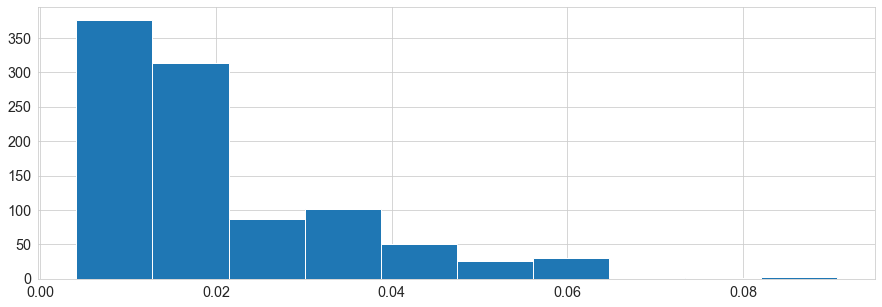

<Figure size 1080x360 with 0 Axes>

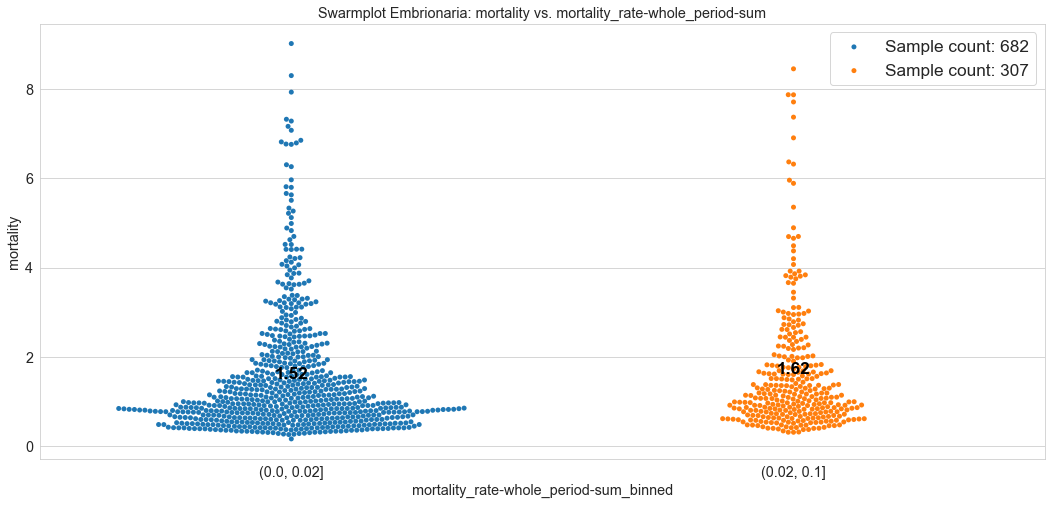

<Figure size 1080x360 with 0 Axes>

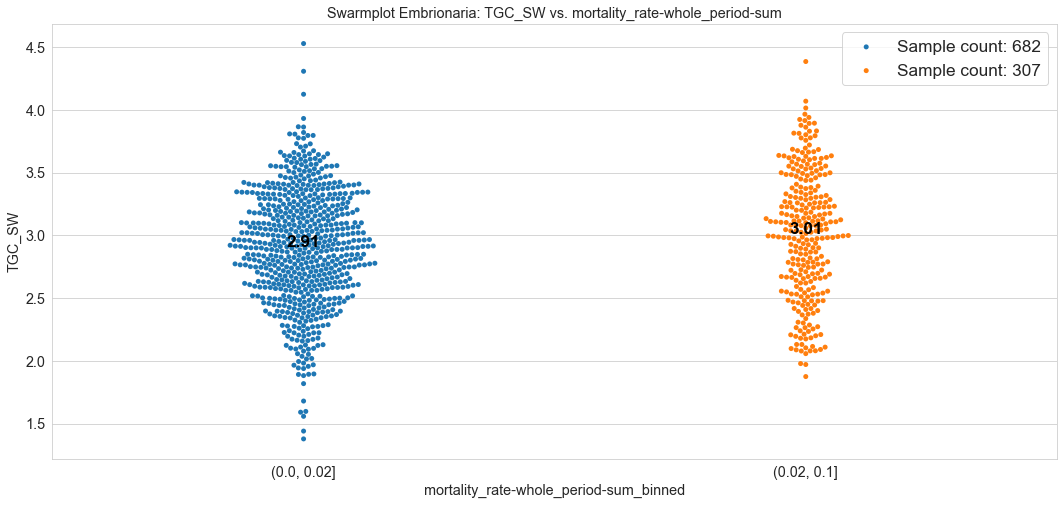

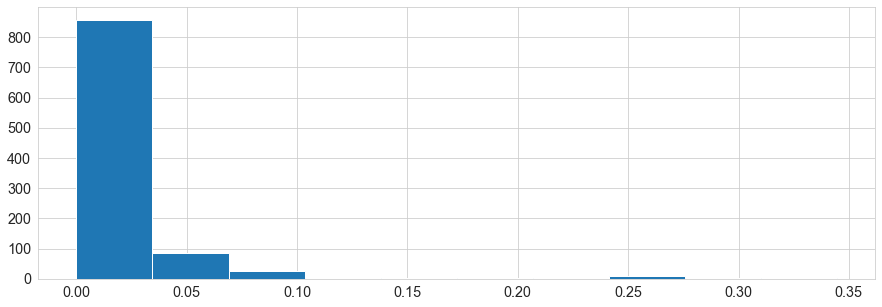

<Figure size 1080x360 with 0 Axes>

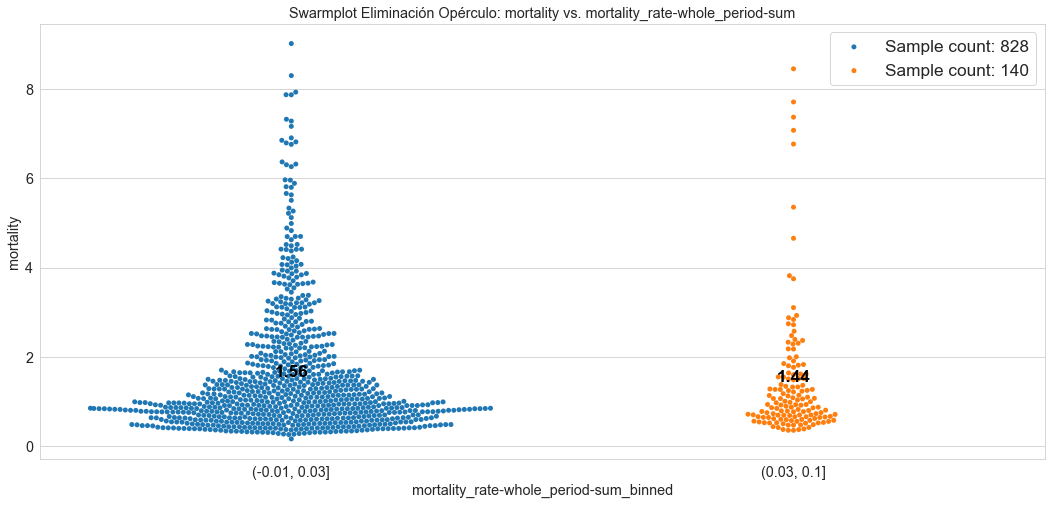

<Figure size 1080x360 with 0 Axes>

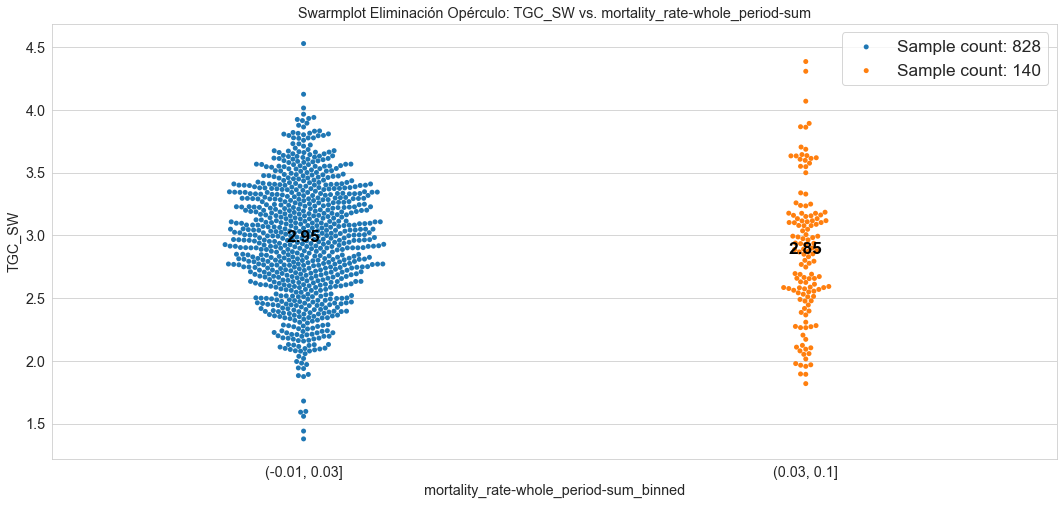

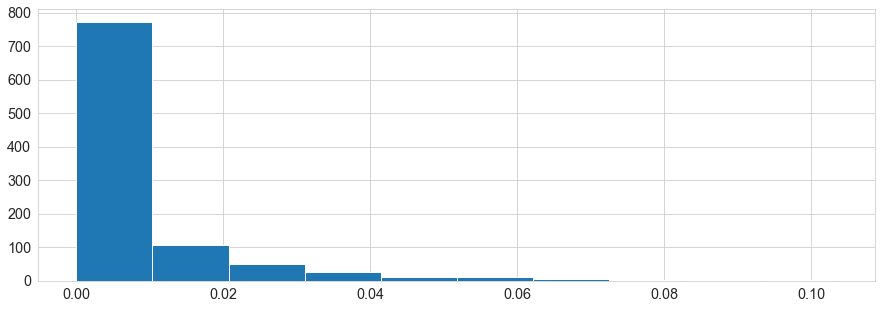

<Figure size 1080x360 with 0 Axes>

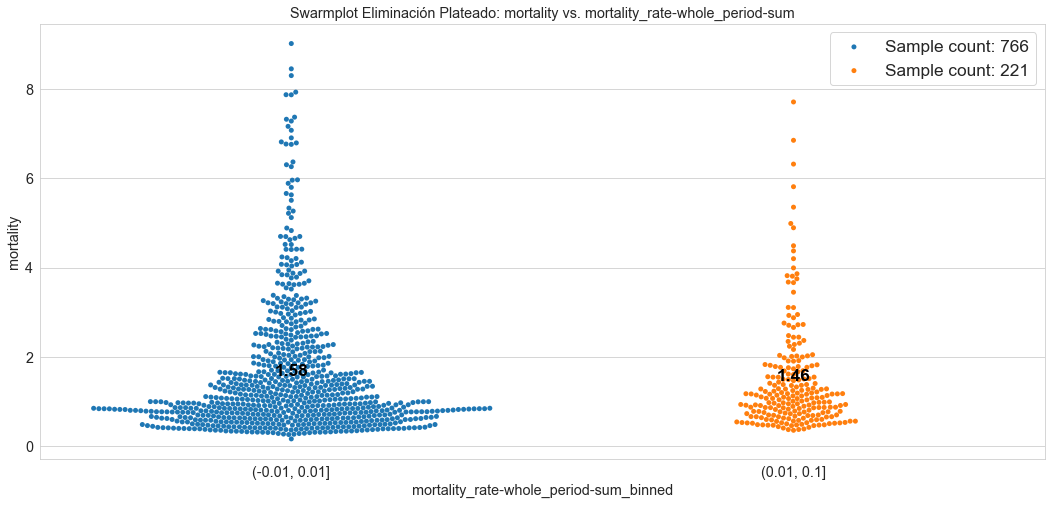

<Figure size 1080x360 with 0 Axes>

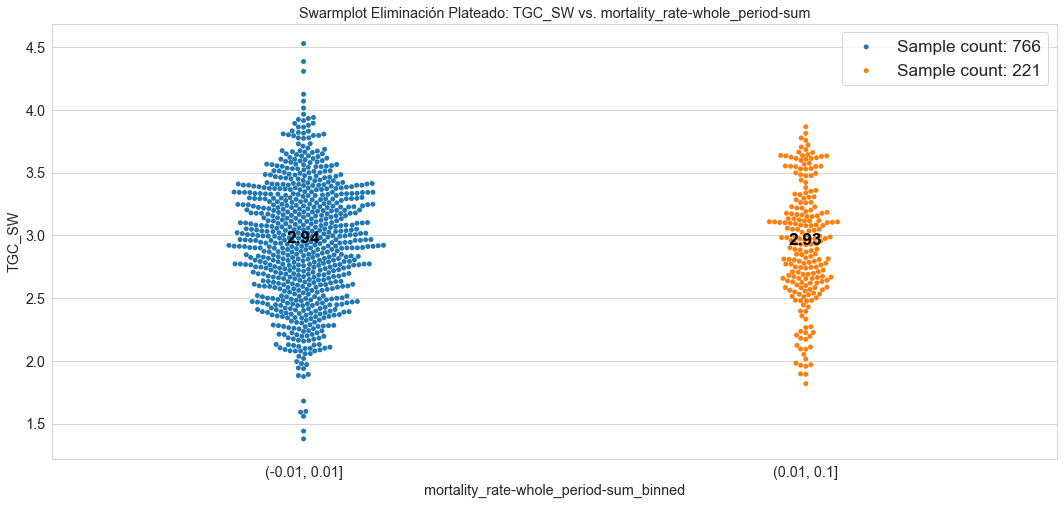

In [16]:
for reason, bins in zip(factors_by_reason, [(0, 0.02, 0.1), (-0.01, 0.03, 0.1), (-0.01, 0.01, 0.1)]):
    factor = f'mortality_rate-whole_period-sum'
    plt.figure()
    factors_by_reason[reason][factor].hist()

    plot_swarm(
        factors_by_reason[reason],
        factor=factor,
        target='mortality',
        bins=bins,
        y_scale=5,
        title=reason
    )
    
    plot_swarm(
        factors_by_reason[reason],
        factor=factor,
        target='TGC_SW',
        bins=bins,
        y_scale=5,
        title=reason
    )

### Finding 2: Sum first_feeding-transfer

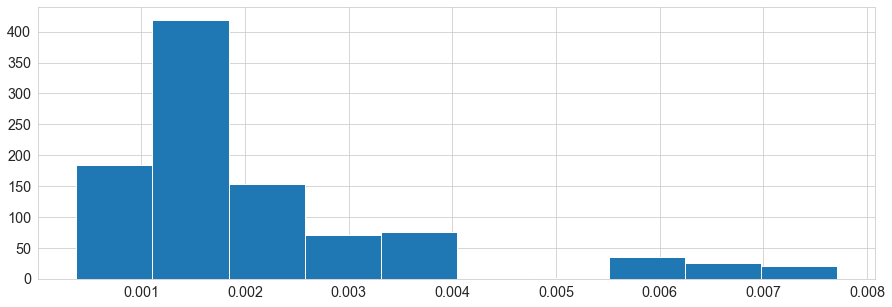

<Figure size 1080x360 with 0 Axes>

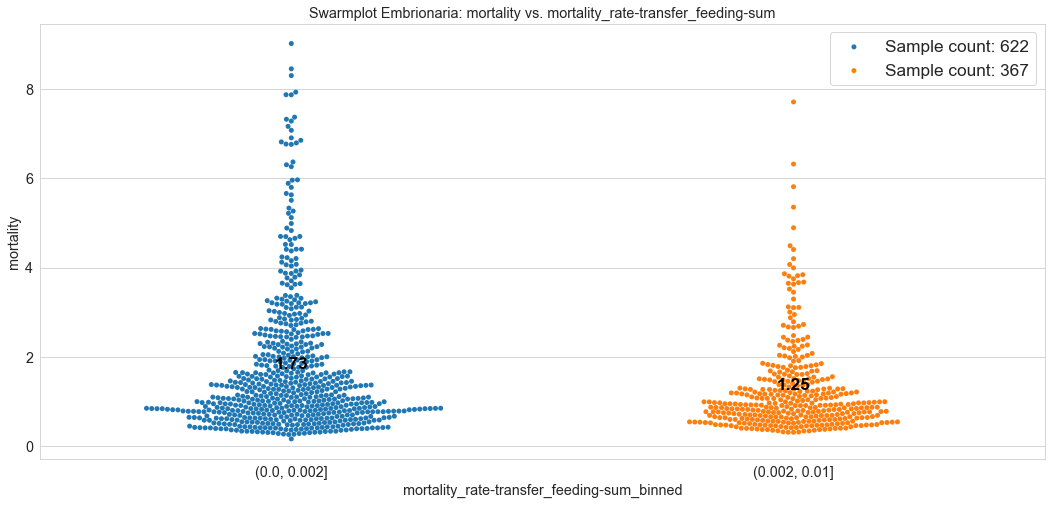

<Figure size 1080x360 with 0 Axes>

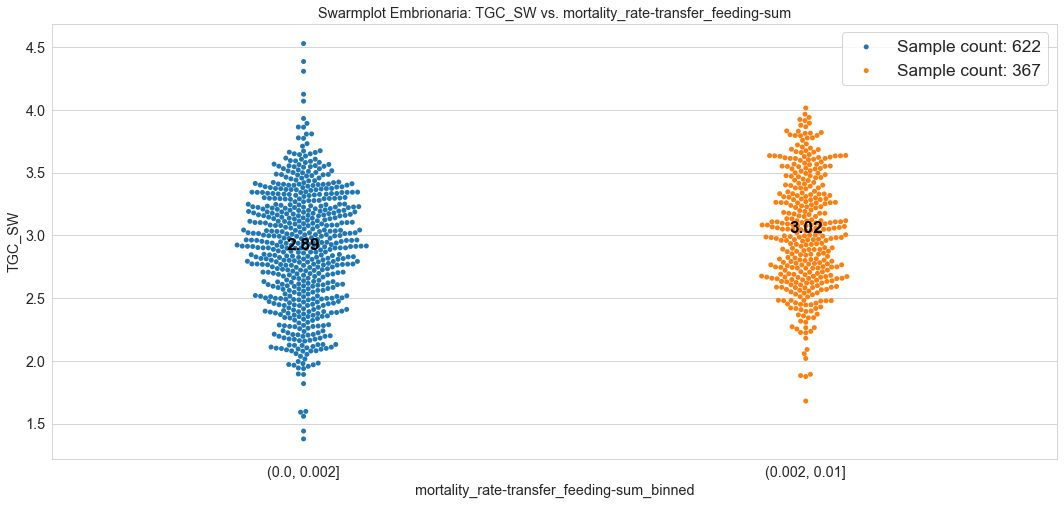

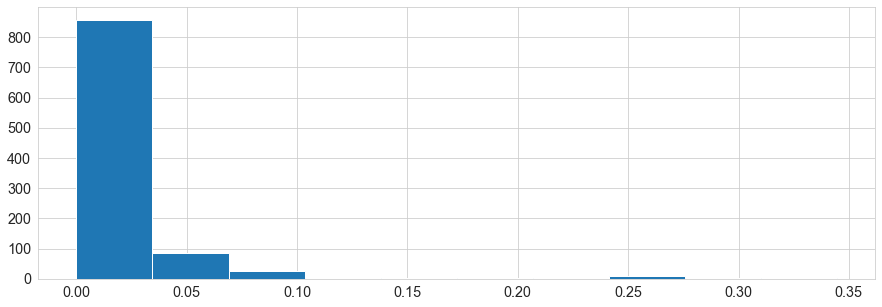

<Figure size 1080x360 with 0 Axes>

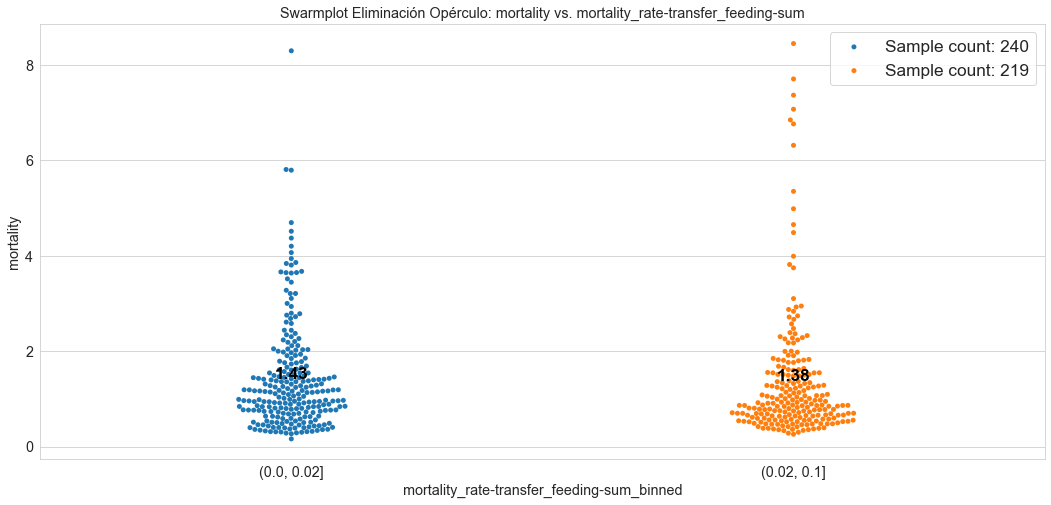

<Figure size 1080x360 with 0 Axes>

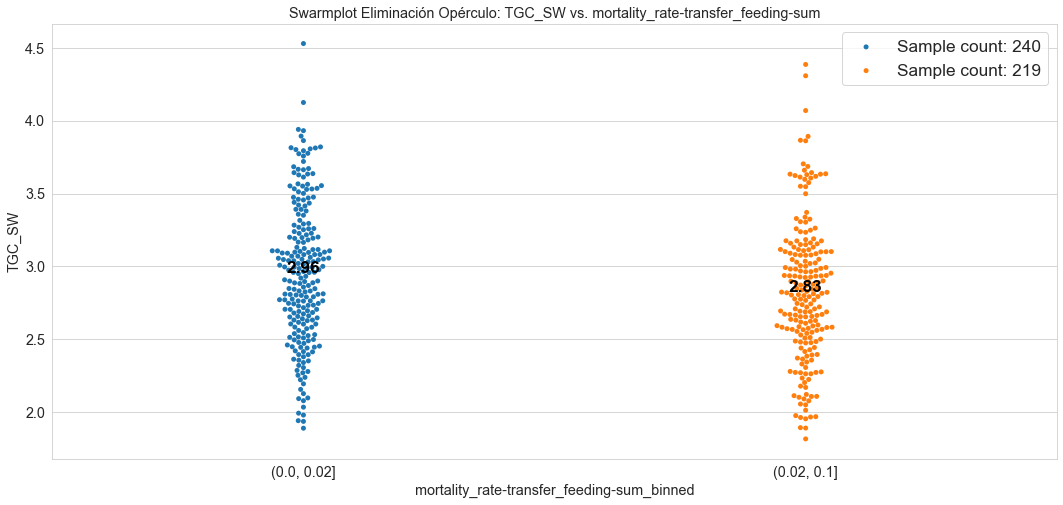

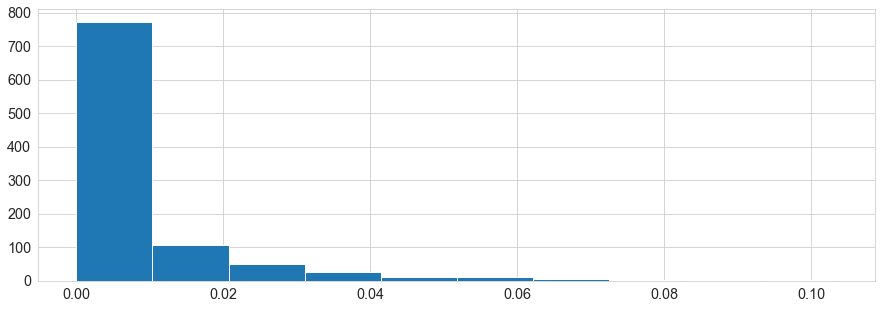

<Figure size 1080x360 with 0 Axes>

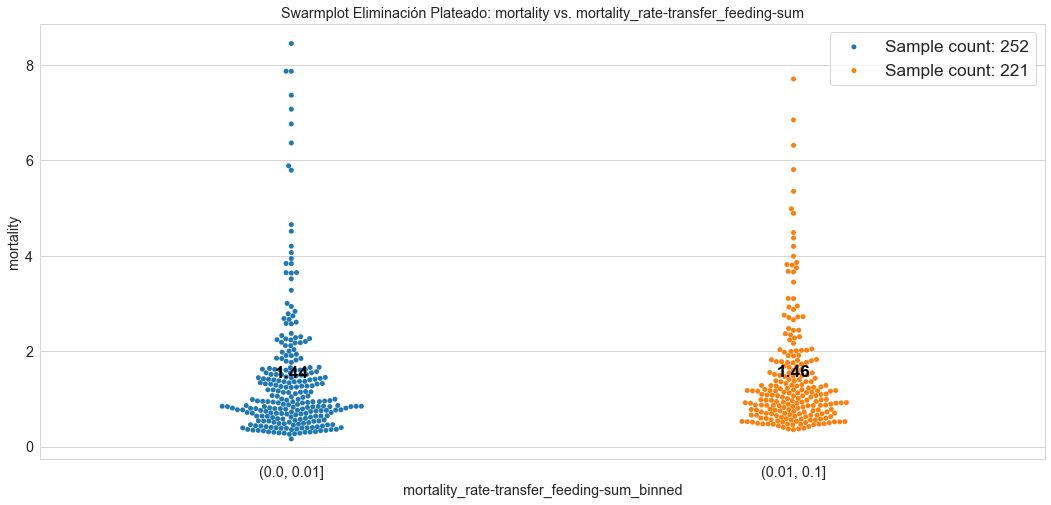

<Figure size 1080x360 with 0 Axes>

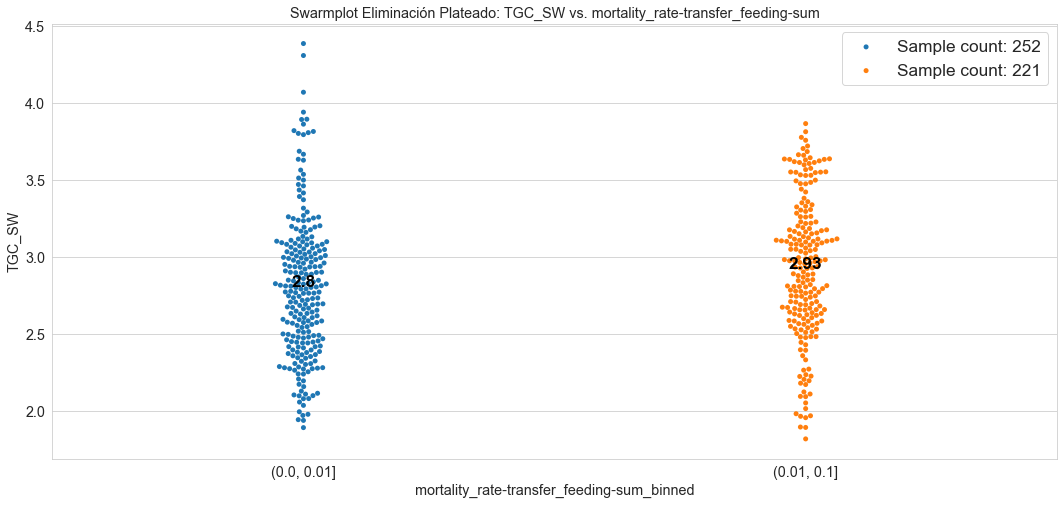

In [17]:
for reason, bins in zip(factors_by_reason, [(0, 0.002, 0.01), (0, 0.02, 0.1), (0, 0.01, 0.1)]):
    factor = f'mortality_rate-transfer_feeding-sum'
    plt.figure()
    factors_by_reason[reason][factor].hist()

    plot_swarm(
        factors_by_reason[reason],
        factor=factor,
        target='mortality',
        bins=bins,
        y_scale=5,
        title=reason
    )
    
    plot_swarm(
        factors_by_reason[reason],
        factor=factor,
        target='TGC_SW',
        bins=bins,
        y_scale=5,
        title=reason
    )

### Finding 3: Sum 4 weeks after first feeding

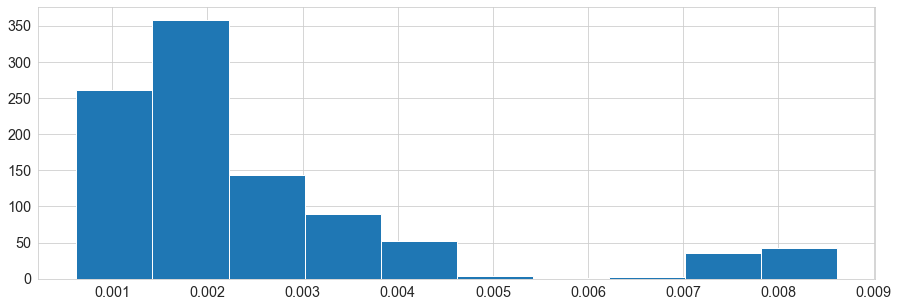

<Figure size 1080x360 with 0 Axes>

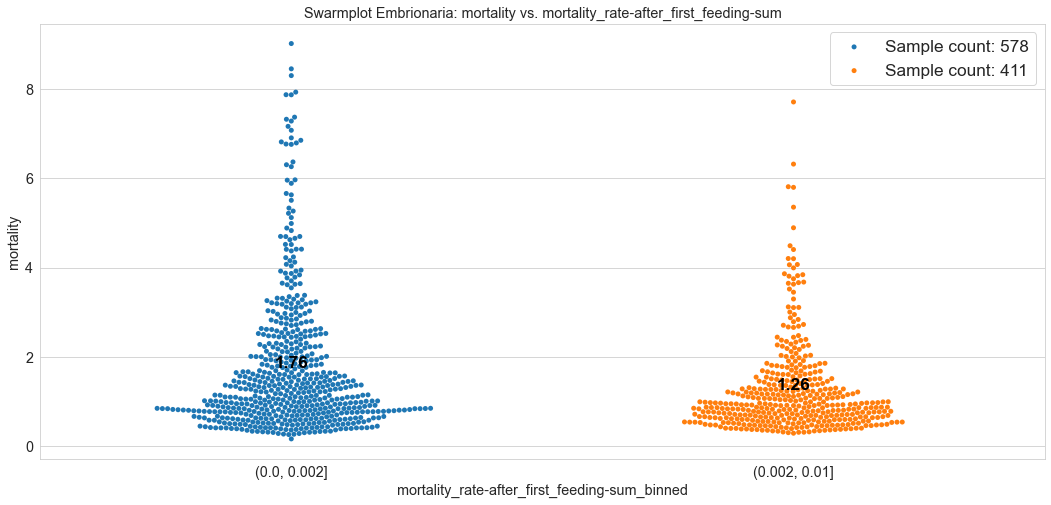

<Figure size 1080x360 with 0 Axes>

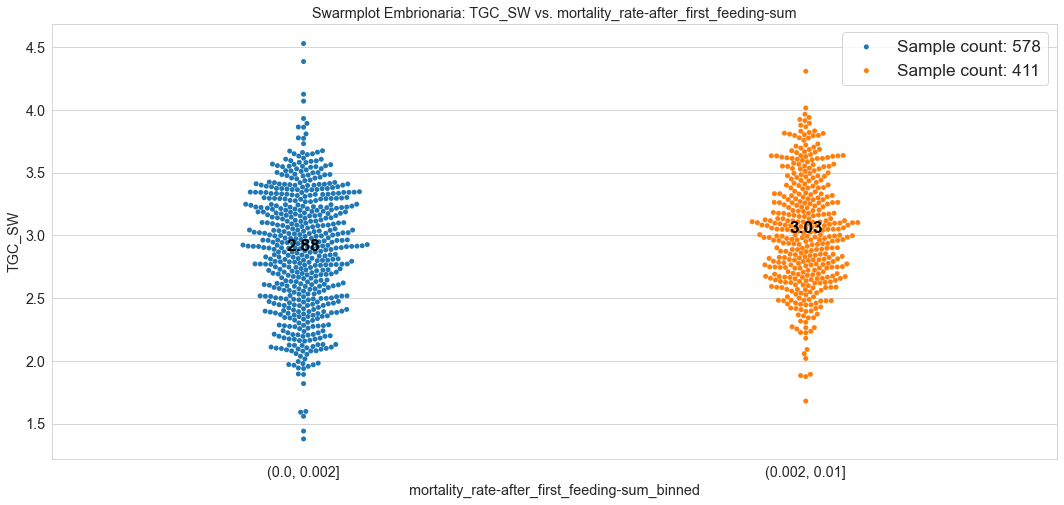

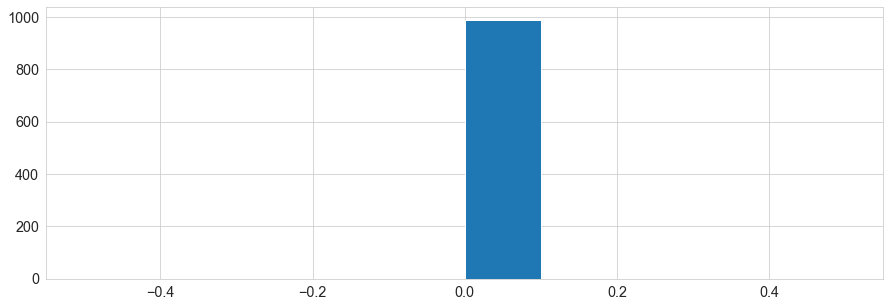

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


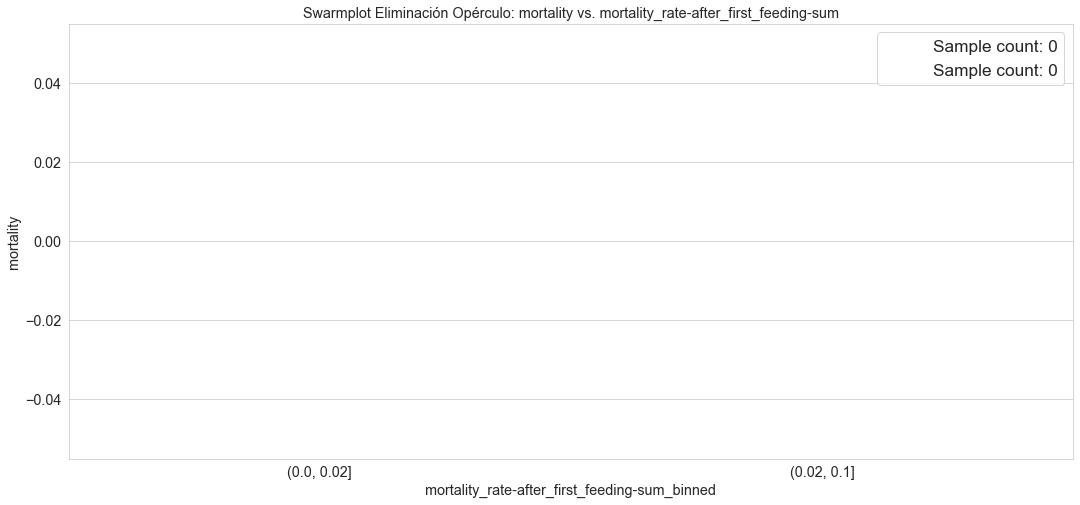

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


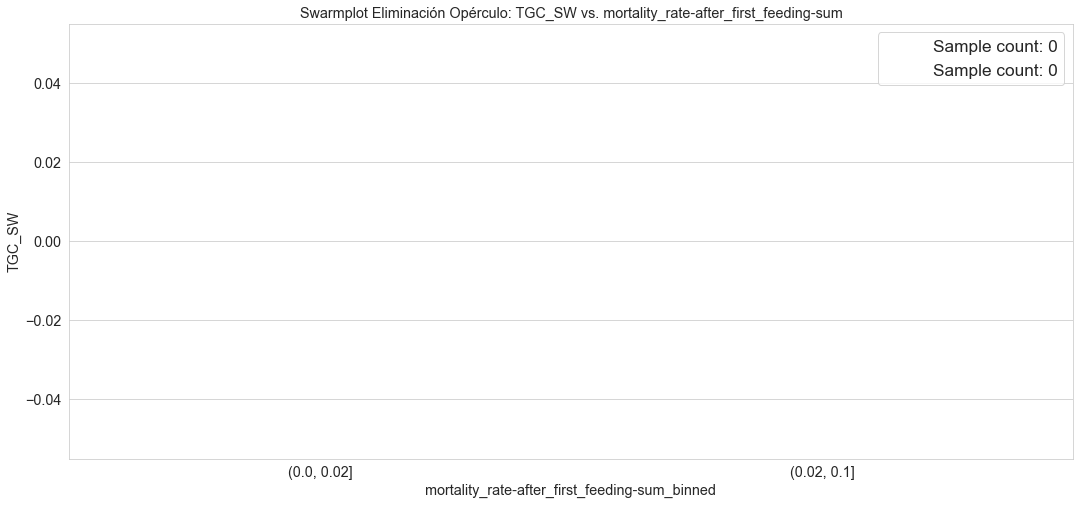

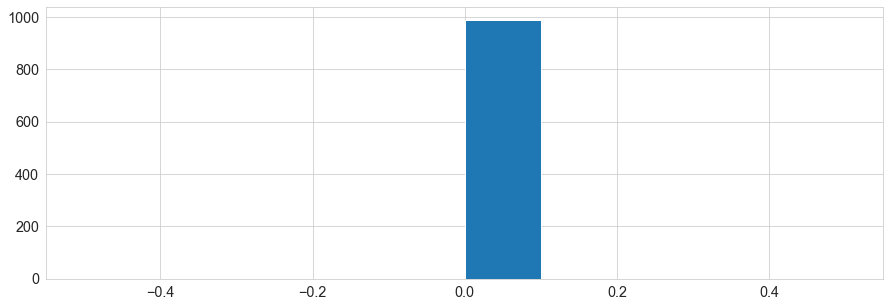

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


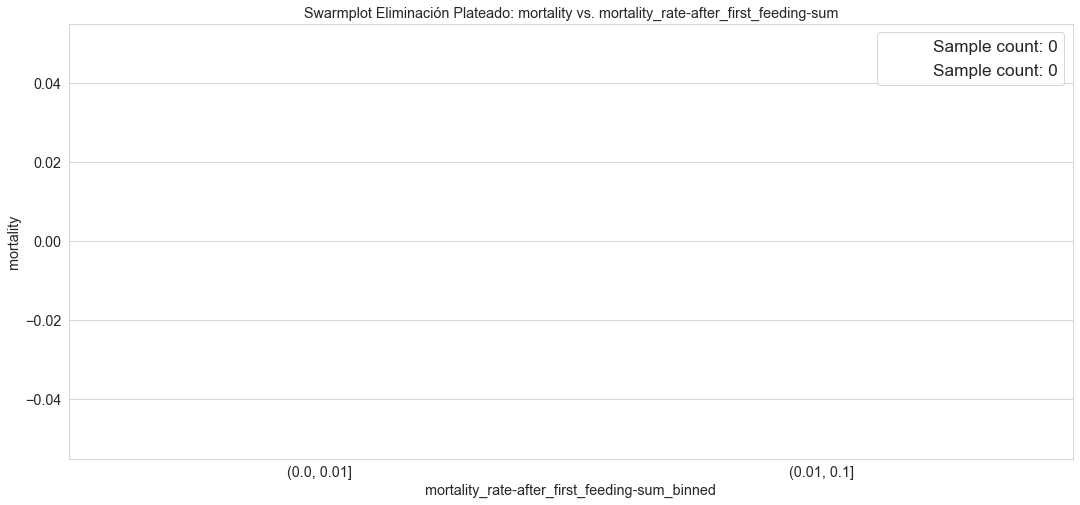

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


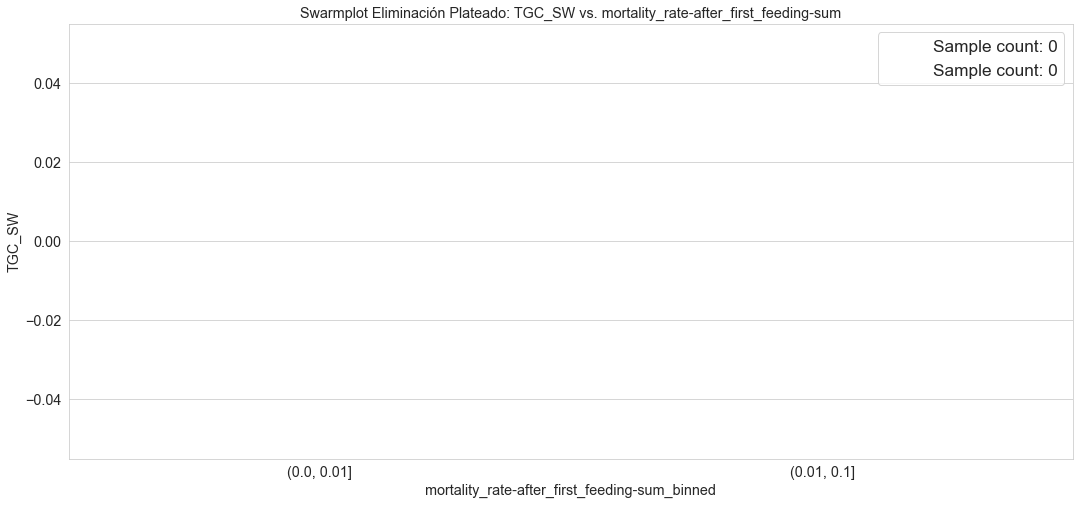

In [18]:
for reason, bins in zip(factors_by_reason, [(0, 0.002, 0.01), (0, 0.02, 0.1), (0, 0.01, 0.1)]):
    factor = f'mortality_rate-after_first_feeding-sum'
    plt.figure()
    factors_by_reason[reason][factor].hist()

    plot_swarm(
        factors_by_reason[reason],
        factor=factor,
        target='mortality',
        bins=bins,
        y_scale=5,
        title=reason
    )
    
    plot_swarm(
        factors_by_reason[reason],
        factor=factor,
        target='TGC_SW',
        bins=bins,
        y_scale=5,
        title=reason
    )

### Finding 4: Sum transfer-vaccination

count    989.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: mortality_rate-transfer_vaccination-sum, dtype: float64

count    989.000000
mean       0.000021
std        0.000528
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.015662
Name: mortality_rate-transfer_vaccination-sum, dtype: float64

count    989.000000
mean       0.000068
std        0.001671
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.049597
Name: mortality_rate-transfer_vaccination-sum, dtype: float64

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values


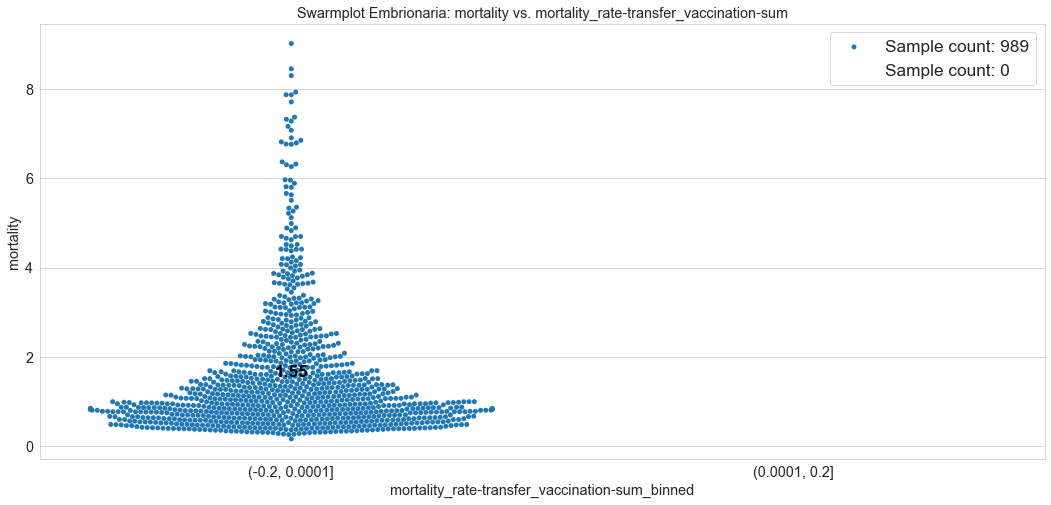

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values


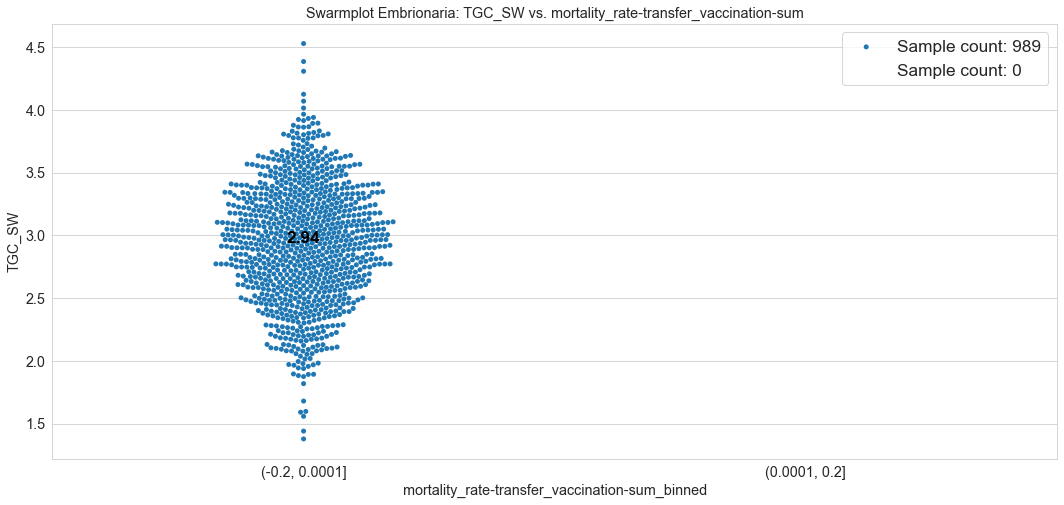

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values


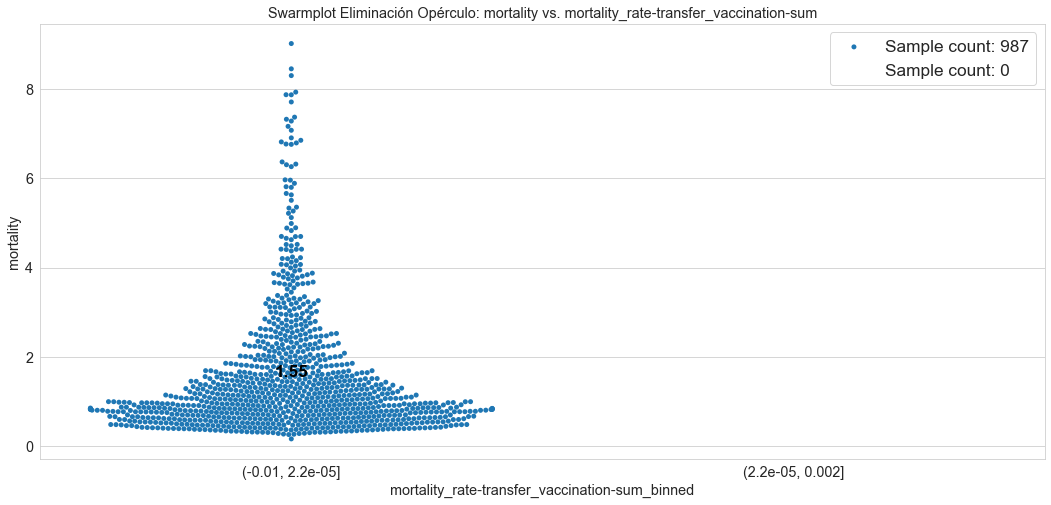

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values


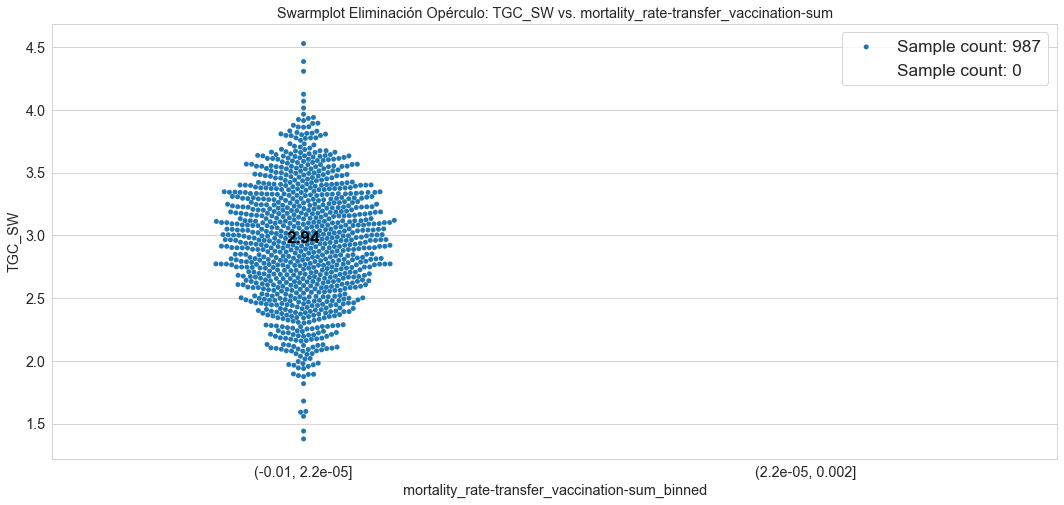

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

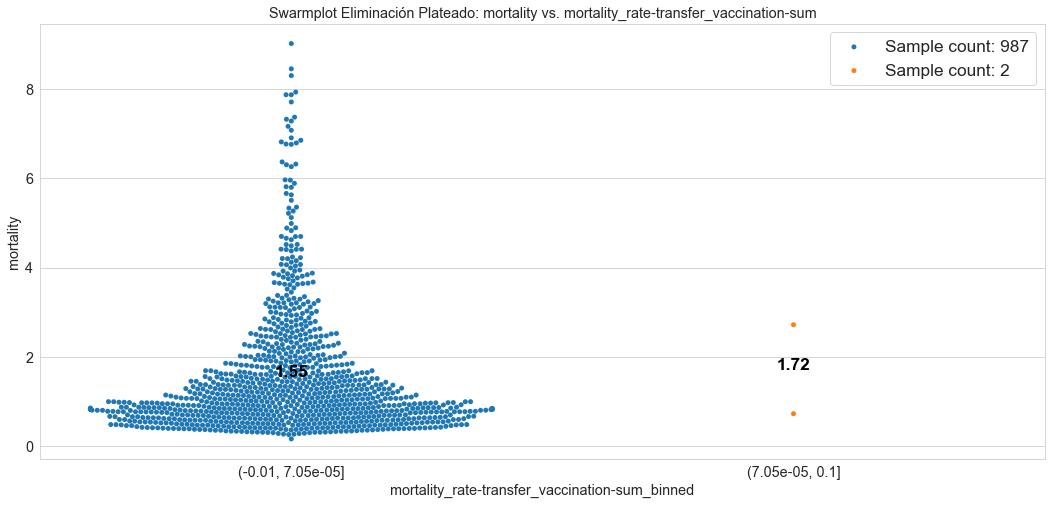

<Figure size 1080x360 with 0 Axes>

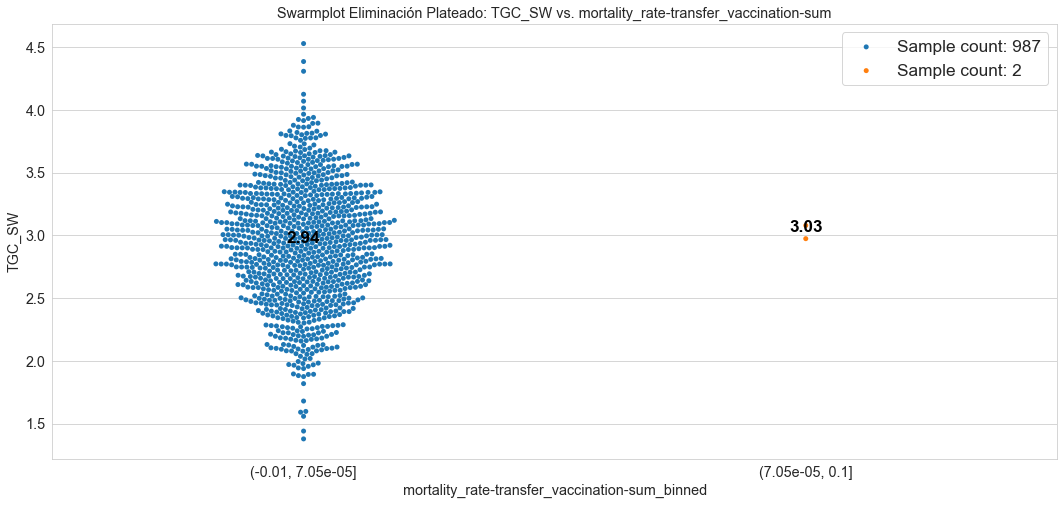

In [19]:
for reason, bins in zip(factors_by_reason, [(-0.2, 0.0001, 0.2), (-0.01, 0.000022, 0.002), (-0.01, 0.000141 / 2, 0.1)]):
    factor = f'mortality_rate-transfer_vaccination-sum'
    plt.figure()
    display(factors_by_reason[reason][factor].describe())

    plot_swarm(
        factors_by_reason[reason],
        factor=factor,
        target='mortality',
        bins=bins,
        y_scale=5,
        title=reason
    )
    
    plot_swarm(
        factors_by_reason[reason],
        factor=factor,
        target='TGC_SW',
        bins=bins,
        y_scale=5,
        title=reason
    )

### Finding 5: Sum first_feeding-vaccination

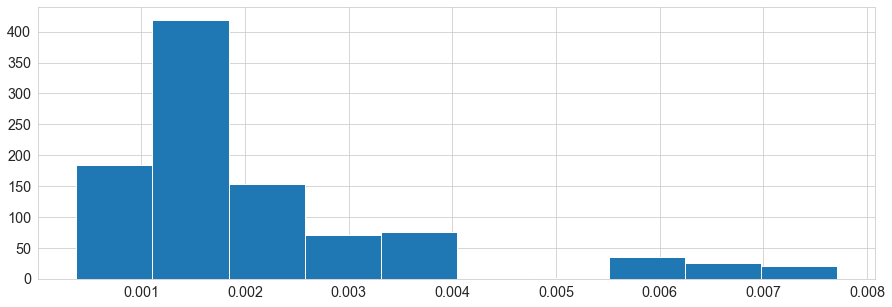

<Figure size 1080x360 with 0 Axes>

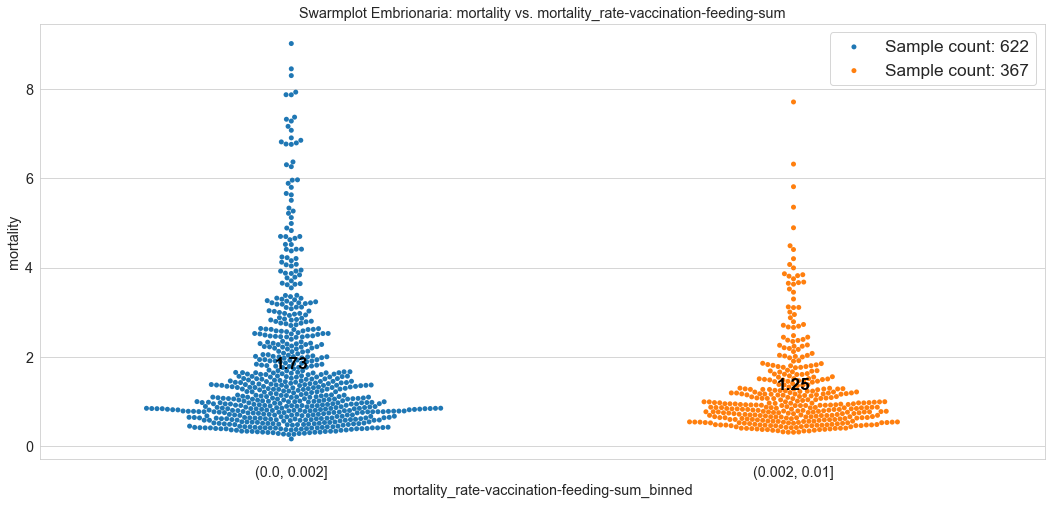

<Figure size 1080x360 with 0 Axes>

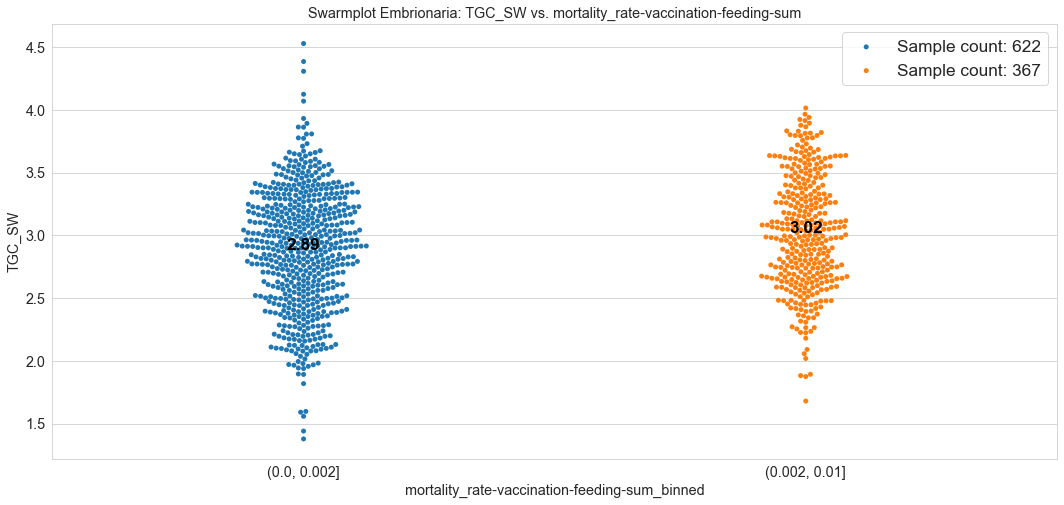

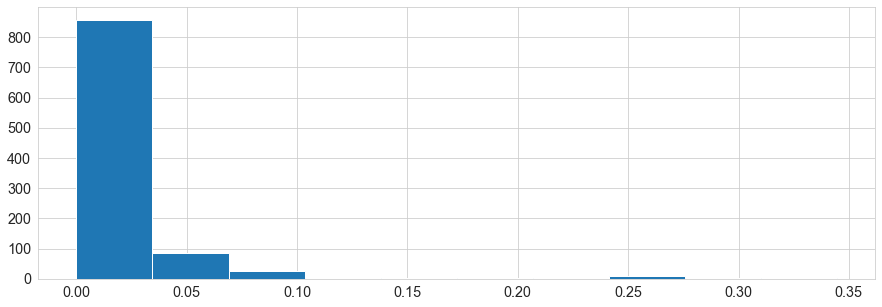

<Figure size 1080x360 with 0 Axes>

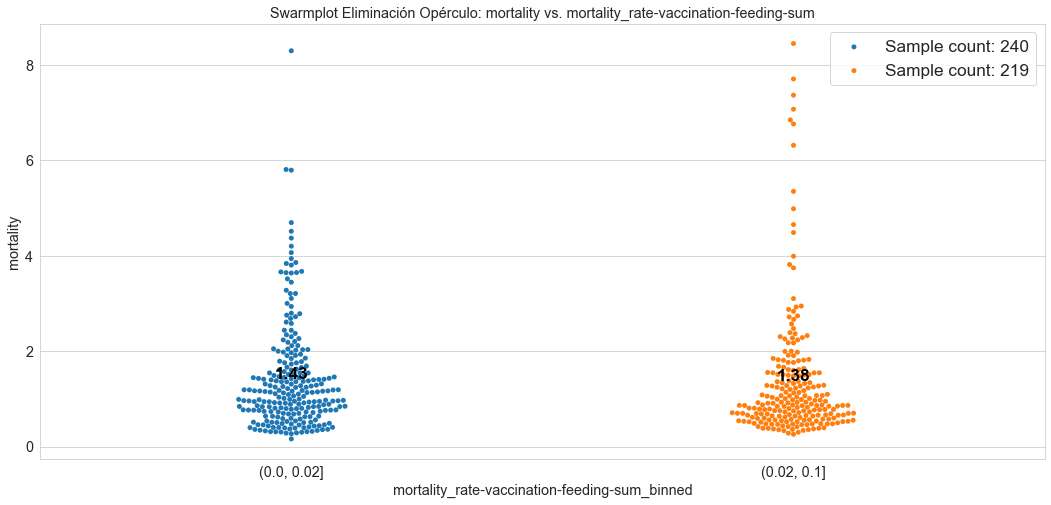

<Figure size 1080x360 with 0 Axes>

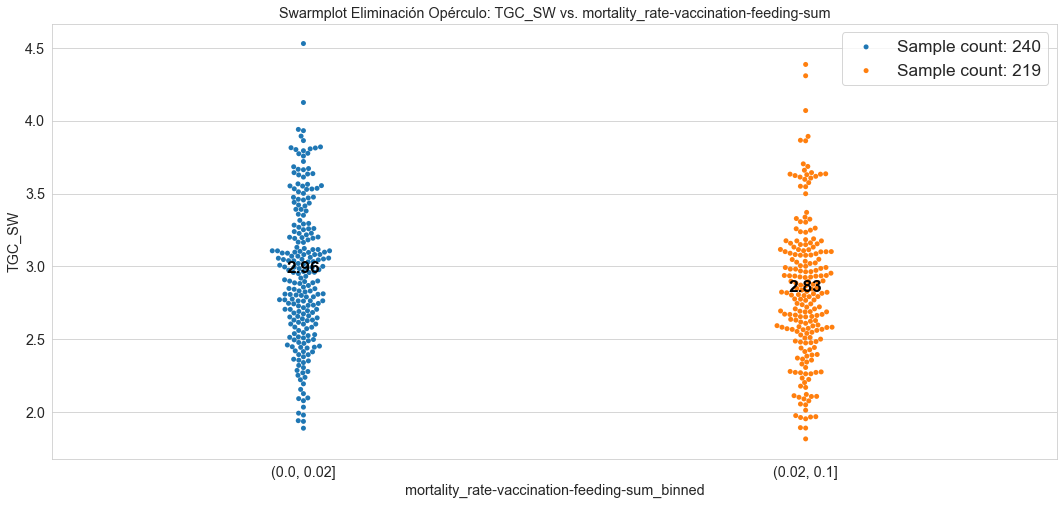

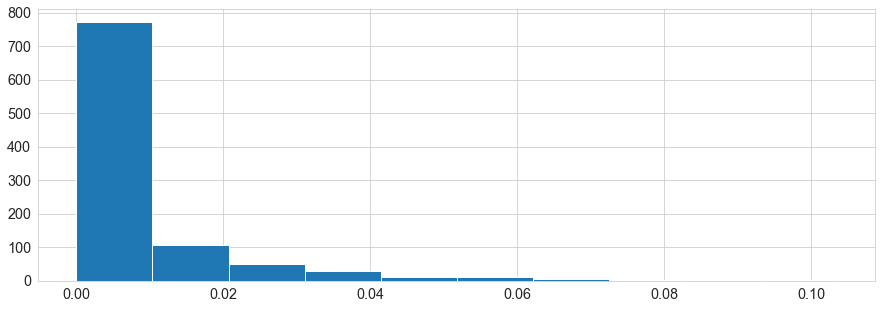

<Figure size 1080x360 with 0 Axes>

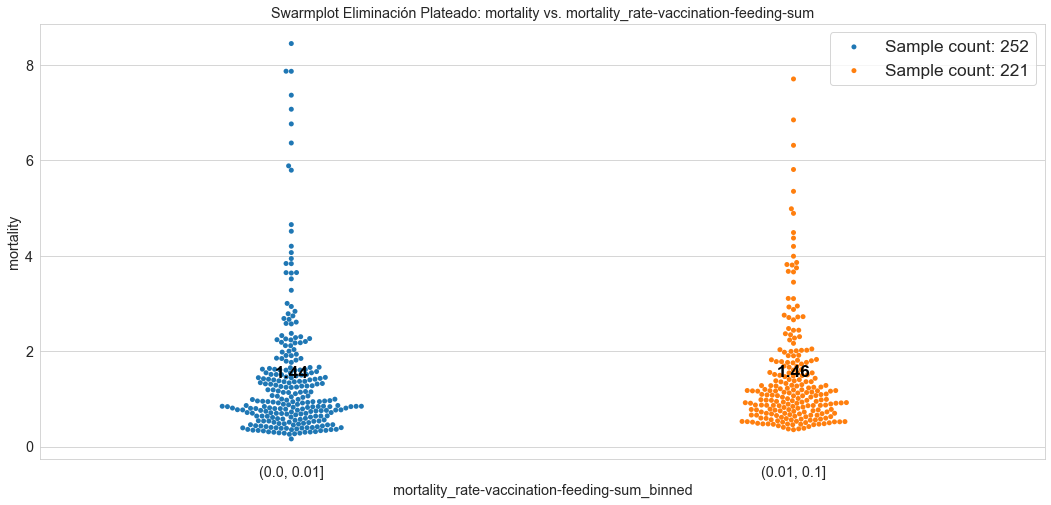

<Figure size 1080x360 with 0 Axes>

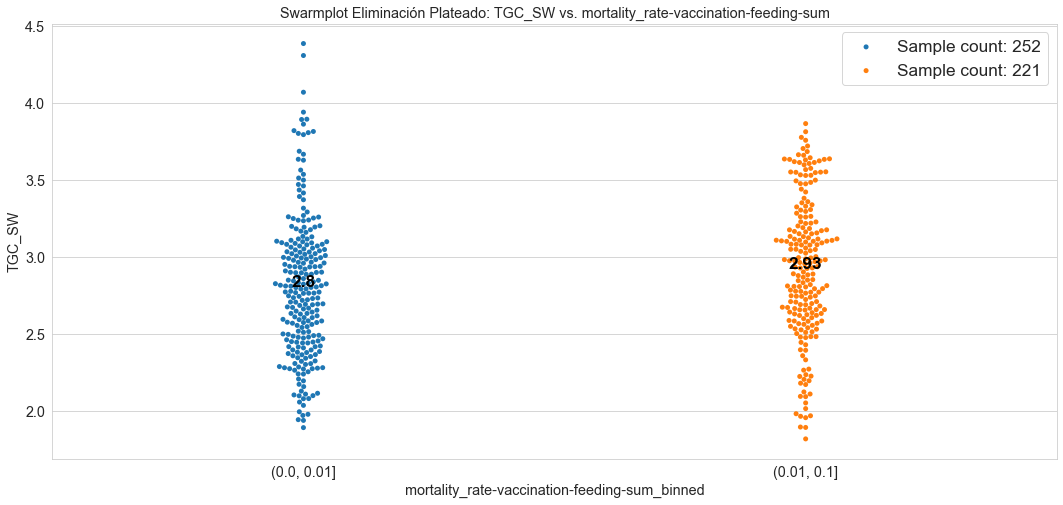

In [20]:
for reason, bins in zip(factors_by_reason, [(0, 0.002, 0.01), (0, 0.02, 0.1), (0, 0.01, 0.1)]):
    factor = f'mortality_rate-vaccination-feeding-sum'
    plt.figure()
    factors_by_reason[reason][factor].hist()

    plot_swarm(
        factors_by_reason[reason],
        factor=factor,
        target='mortality',
        bins=bins,
        y_scale=5,
        title=reason
    )
    
    plot_swarm(
        factors_by_reason[reason],
        factor=factor,
        target='TGC_SW',
        bins=bins,
        y_scale=5,
        title=reason
    )

### Findnig 6: Week around vaccintion

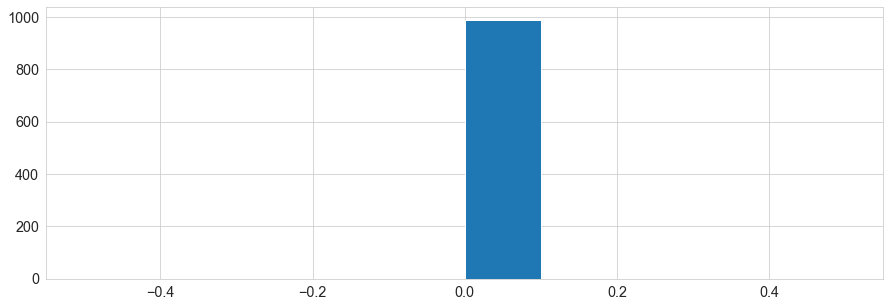

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values


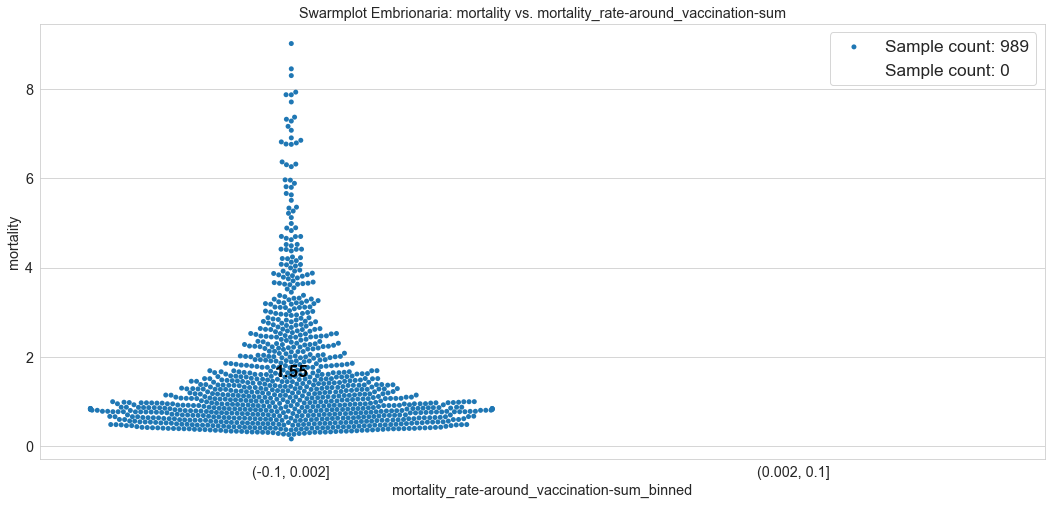

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values


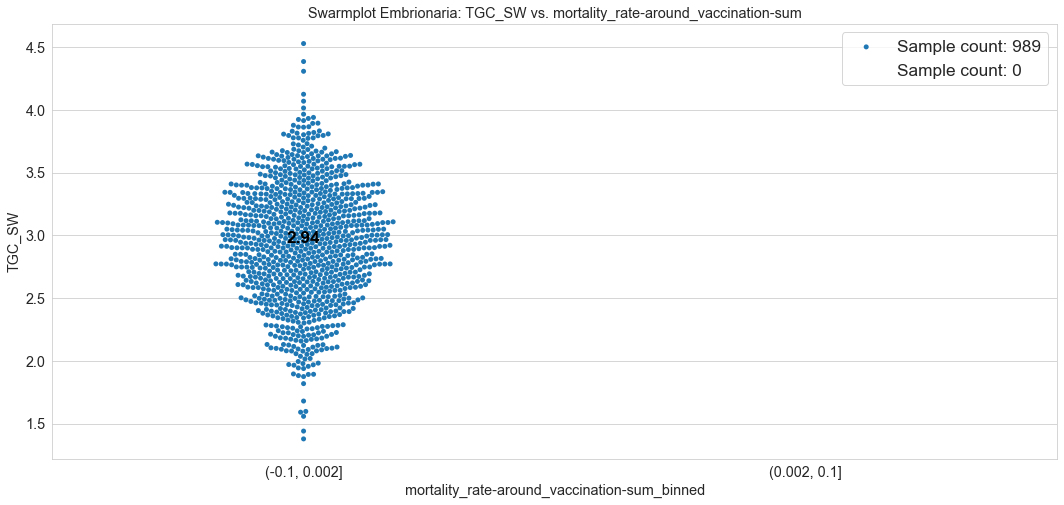

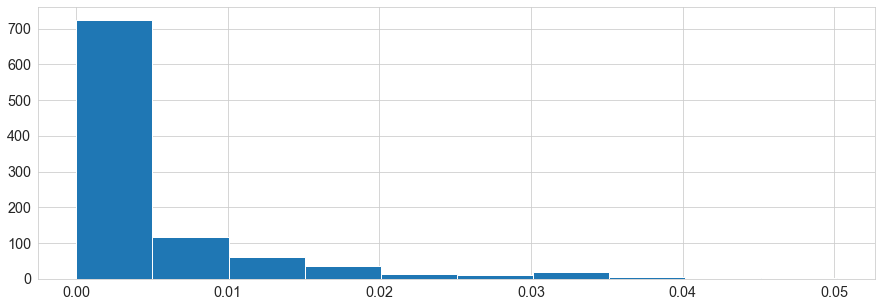

<Figure size 1080x360 with 0 Axes>

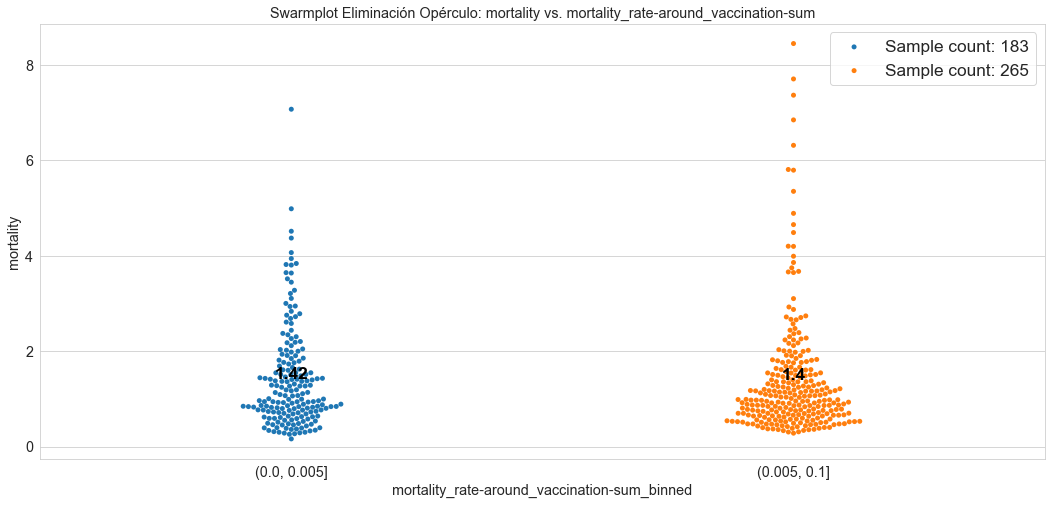

<Figure size 1080x360 with 0 Axes>

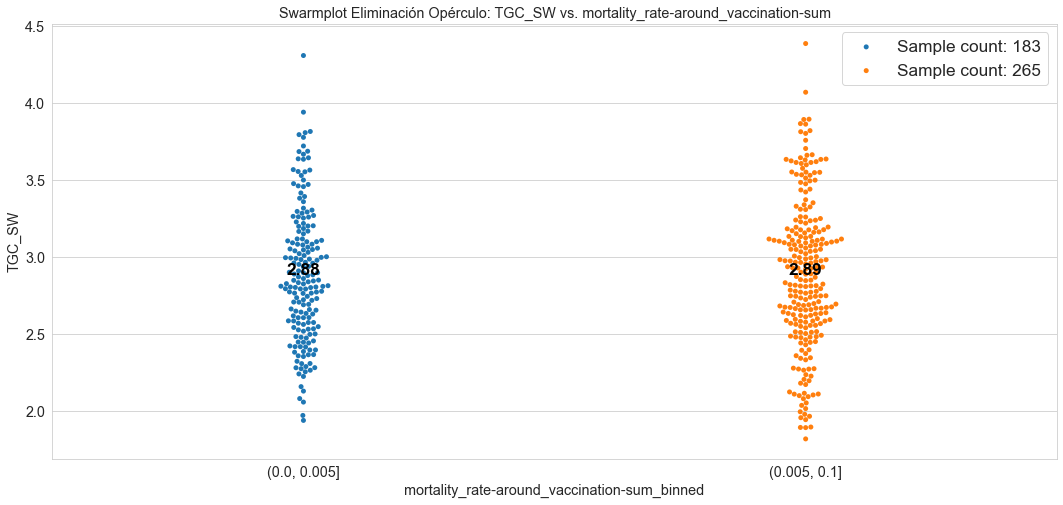

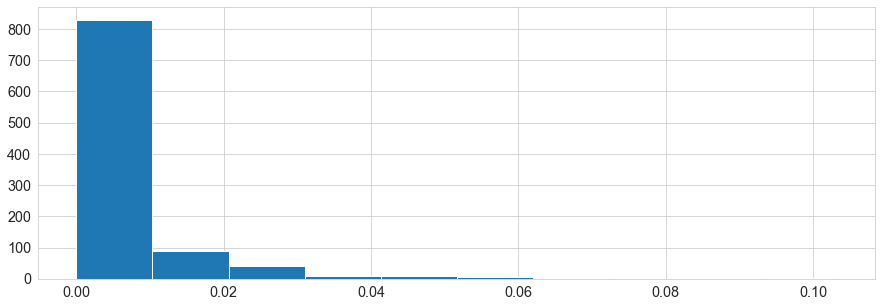

<Figure size 1080x360 with 0 Axes>

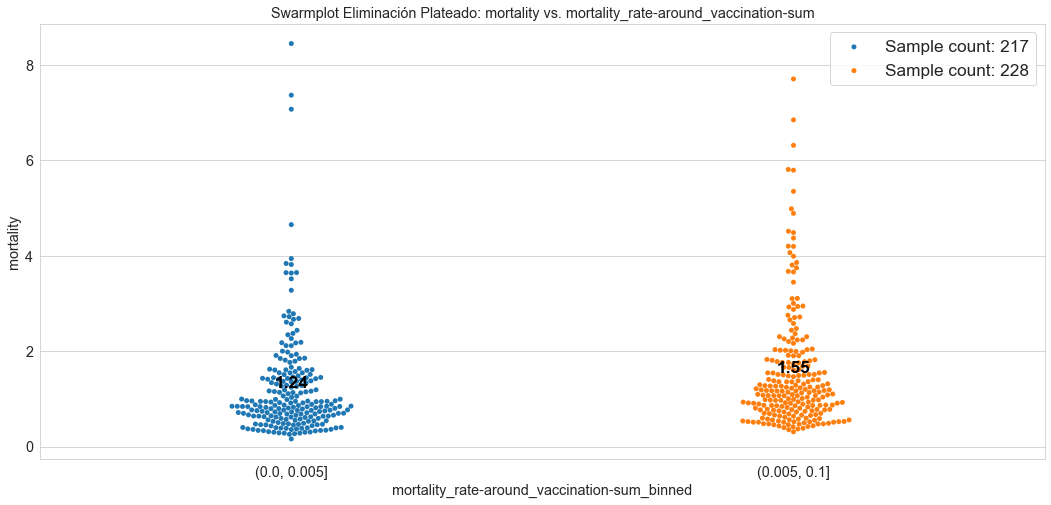

<Figure size 1080x360 with 0 Axes>

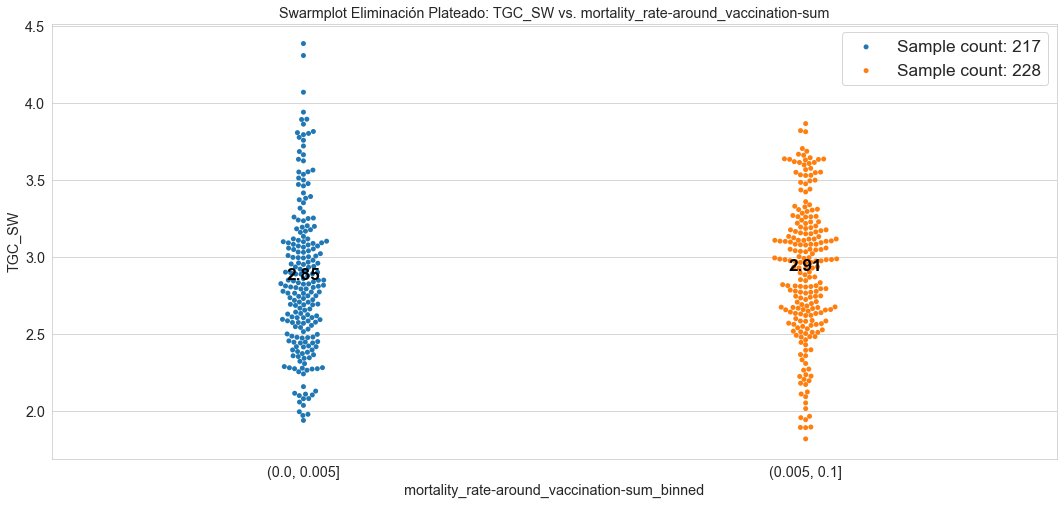

In [21]:
for reason, bins in zip(factors_by_reason, [(-0.1, 0.002, 0.1), (0, 0.01 / 2, 0.1), (0, 0.01 / 2, 0.1)]):
    factor = f'mortality_rate-around_vaccination-sum'
    plt.figure()
    factors_by_reason[reason][factor].hist()

    plot_swarm(
        factors_by_reason[reason],
        factor=factor,
        target='mortality',
        bins=bins,
        y_scale=5,
        title=reason
    )
    
    plot_swarm(
        factors_by_reason[reason],
        factor=factor,
        target='TGC_SW',
        bins=bins,
        y_scale=5,
        title=reason
    )